In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import sys  
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir
tweets_dir  = "/Users/caihao/Dropbox/TEMP/tweets/"

In [20]:
# 2012 cmu_crunchbase dataset. This is the dataset used for finding Twitter names for companies.
df_2012 = pd.read_csv(processed_data_dir + '/' + 'cmu_cb_company.csv')
print(df_2012.count())
print(df_2012.apply(len))

name                   79109
overview               60744
description            46165
category_code          57834
permalink              79110
crunchbase_url         79111
homepage_url           61192
blog_url               23653
blog_feed_url          13462
twitter_username       29786
number_of_employees    33422
founded_year           44927
founded_month          29371
founded_day            21061
competitions           79111
total_money_raised     79111
funding_rounds         79111
investments            79111
acquisition             5604
acquisitions           79111
milestones             79111
ipo                      629
tag_list               40280
dtype: int64
name                   79111
overview               79111
description            79111
category_code          79111
permalink              79111
crunchbase_url         79111
homepage_url           79111
blog_url               79111
blog_feed_url          79111
twitter_username       79111
number_of_employees    79111
f

There are a lot of missing data for column "description", "blog_url", "twitter_username" and "acquisition". Next I want to select company with Twitter accounts.

In [21]:
# select companies with Twitter account.
companies_twit = df_2012.loc[df_2012.twitter_username.notnull()].copy()
companies_twit['permalink'] = '/organization/' + companies_twit['permalink']
companies_twit.count()

name                   29786
overview               28282
description            27425
category_code          28813
permalink              29786
crunchbase_url         29786
homepage_url           29681
blog_url               17437
blog_feed_url           9632
twitter_username       29786
number_of_employees    21833
founded_year           25379
founded_month          19010
founded_day            13479
competitions           29786
total_money_raised     29786
funding_rounds         29786
investments            29786
acquisition              748
acquisitions           29786
milestones             29786
ipo                       91
tag_list               24917
dtype: int64

In [70]:
# 2014 datanerd crunchbase dataset. This is the dataset with funding rounds information.
df_2014 = pd.read_csv(processed_data_dir + '/' + 'datanerd_cb_company.csv')
df_2014.count()

permalink            49438
name                 49437
homepage_url         45984
category_list        45477
market               45470
funding_total_usd    49438
status               48124
country_code         44165
state_code           30161
region               44165
city                 43322
funding_rounds       49438
founded_at           38554
founded_month        38482
founded_quarter      38482
founded_year         38482
first_funding_at     49438
last_funding_at      49438
dtype: int64

In [71]:
# merge 2012 and 2014 datasets to get companies with funding rounds information and twitter accounts.
companies_twit_username = companies_twit[['permalink', 'twitter_username']].copy()
df_2014_new = df_2014.merge(companies_twit_username, on='permalink', )
print(len(df_2014_new))
print(df_2014_new.count())

6735
permalink            6735
name                 6735
homepage_url         6711
category_list        6706
market               6706
funding_total_usd    6735
status               6588
country_code         6241
state_code           4351
region               6241
city                 6211
funding_rounds       6735
founded_at           6378
founded_month        6375
founded_quarter      6375
founded_year         6375
first_funding_at     6735
last_funding_at      6735
twitter_username     6735
dtype: int64


In [76]:
# save merged dataset.
# df_2014_new.to_csv(processed_data_dir + '/' + 'merged_cb_company_2014_hastwitter.csv', index=False)
df_2014_new = pd.read_csv(processed_data_dir + '/' + 'merged_cb_company_2014_hastwitter.csv')
print(df_2014_new.columns)

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username'],
      dtype='object')


In [77]:
# convert funding timestamp format.
df_2014_new['last_funding_at'] = pd.to_datetime(df_2014_new['last_funding_at'])
df_2014_new['first_funding_at'] = pd.to_datetime(df_2014_new['first_funding_at'])
print(df_2014_new.columns)

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username'],
      dtype='object')


6735


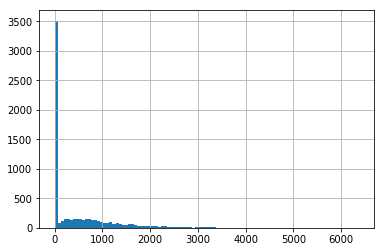

In [79]:
# distribution of time period between two funding rounds.
df_2014_new['first2last_funding_days'] = (df_2014_new.last_funding_at - df_2014_new.first_funding_at).dt.days
print(df_2014_new.first2last_funding_days.count())
df_2014_new.first2last_funding_days.hist(bins=100)
plt.show()

In [80]:
# set the start and end date for twitterscraper.

# set the start date as 1 year before first funding.
df_2014_new['twit_since'] = df_2014_new.first_funding_at - pd.to_timedelta('365 days')

# set the end date as 1 year after last funding
df_2014_new['twit_until'] = df_2014_new.last_funding_at + pd.to_timedelta('365 days')

# save the twitter username, since_date, until_date
print(df_2014_new[['twitter_username', 'twit_since', 'twit_until']].head())
# df_2014_new[['twitter_username', 'twit_since', 'twit_until']].to_csv(processed_data_dir + '/' + 'company_2014_twitter_info.csv', index=False)

  twitter_username twit_since twit_until
0          waywire 2011-07-01 2013-06-30
1          100Plus 2010-11-02 2012-11-29
2        15fiveinc 2011-01-01 2015-10-02
3        1DayLater 2008-05-01 2010-10-01
4           20x200 2008-10-01 2011-08-01


In [94]:
# Find all companies that went through series B and also has scraped twitter data ready by now.
import os
x_series_companies = df_2014_new.loc[df_2014_new.funding_rounds>0].twitter_username.tolist()
tweeted_companies = [s[:-4] for s in os.listdir(tweets_dir)]
x_series_tweeted_companies = list(set(x_series_companies) & set(tweeted_companies))
df_2014_series_x_tweeted = df_2014_new.loc[df_2014_new.twitter_username.isin(x_series_tweeted_companies)]
# df_2014_series_x_tweeted.to_csv(processed_data_dir + '/companies_2014_series_all_tweeted.csv', index=False)
print(len(df_2014_series_x_tweeted))
print(df_2014_series_x_tweeted.head())
# print(df_2014_series_x_tweeted.funding_rounds.value_counts(normalize=True))

738
1    0.449864
2    0.247967
3    0.134146
4    0.069106
5    0.050136
6    0.020325
7    0.017615
8    0.008130
9    0.002710
Name: funding_rounds, dtype: float64


In [58]:
# For a company that went through series B and has twitter data, look at what the twitter data looks like.
pd.set_option('display.max_columns', None)

def a2b_time(twitter_username):
    company_row = df_2014_new.loc[df_2014_new.twitter_username == twitter_username]
    series_a_time = company_row.first_funding_at
    series_b_time = company_row.last_funding_at
    a2b_time = (series_b_time - series_a_time).dt.days.values[0]
    return a2b_time
    
def tweets_stats(twitter_username):
    tweet_file_path = tweets_dir + '/' + twitter_username + '.csv'
    tweet_df = pd.read_csv(tweet_file_path, delimiter=';')
    tweet_num = len(tweet_df)
    return tweet_df

print(a2b_time('8tracks'))
print(tweets_stats('8tracks').columns)
print(tweets_stats('8tracks').head())

671
Index(['screen_name', 'username', 'user_id', 'tweet_id', 'tweet_url',
       'timestamp', 'timestamp_epochs', 'text', 'text_html', 'links',
       'hashtags', 'has_media', 'img_urls', 'video_url', 'likes', 'retweets',
       'replies', 'is_replied', 'is_reply_to', 'parent_tweet_id',
       'reply_to_users'],
      dtype='object')
  screen_name username  user_id            tweet_id  \
0     8tracks  8tracks  6632072  210068189474852864   
1     8tracks  8tracks  6632072  208710961077567489   
2     8tracks  8tracks  6632072  208281849645117442   
3     8tracks  8tracks  6632072  208279345993744384   
4     8tracks  8tracks  6632072  208058336145444865   

                            tweet_url            timestamp  timestamp_epochs  \
0  /8tracks/status/210068189474852864  2012-06-05 17:58:53        1338919133   
1  /8tracks/status/208710961077567489  2012-06-02 00:05:45        1338595545   
2  /8tracks/status/208281849645117442  2012-05-31 19:40:37        1338493237   
3  /8tracks/s